In [2]:
%matplotlib inline 
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pprint import pprint
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import ttest_ind
import calendar

matplotlib.style.use('seaborn-deep')
matplotlib.style.use('seaborn-talk')
thesis_path = "/Users/michaelvasiliou/Documents/Coding/BA Thesis/"
plot_path = thesis_path + "Viz/"

fb_file = thesis_path + "FB_posts_cand.csv"
tw_file = thesis_path + "TW_posts_cand.csv"
social_path = thesis_path+"social_data/"
camp_fb_file = social_path + "statuses/camp/camp_statuses_final.csv"
gov_fb_file = social_path + "statuses/gov/gov_statuses_final.csv"
camp_tweet_file = social_path + "tweets/camp/camp_tweets_final.csv"
gov_tweet_file = social_path + "tweets/gov/gov_tweets_final.csv"
cand_file = thesis_path + "bio_full.csv"

In [3]:
def setup_post_df(df):
    df['weekday'] = df['just_date'].dt.dayofweek.astype('float')
    df['days_before'] = (pd.to_datetime('2016-11-08') - df['just_date']).astype('timedelta64[D]')
    dates = pd.read_csv('just_date.csv')
    dates['just_date'] = pd.to_datetime(dates['just_date'])
    df = df.merge(dates, on='just_date')
    return df

def get_num_posts(df, cand_id):
    return len(df[df['cand_id'] == cand_id])

def get_length(df, cand_id):
    return df[df['cand_id'] == cand_id]['message_length'].mean()

def get_words(df, cand_id):
    return df[df['cand_id'] == cand_id]['num_words'].mean()

def setup_cand_df(cand_df):
    col = ['cand_id', 'num_posts_camp_fb','num_posts_gov_fb','num_posts_camp_tw','num_posts_gov_tw', 'length_camp_fb', 'length_gov_fb','length_camptw', 'length_govtw',
          'words_camp_fb', 'words_govfb', 'words_camptw', 'words_govtw']
    freq = []
    for i in range(1,1196):
        num_campfb = get_num_posts(camp_fb_df, i)
        num_govfb = get_num_posts(gov_fb_df, i)
        num_camptw = get_num_posts(camp_tw_df, i)
        num_govtw = get_num_posts(gov_tw_df, i)
        length_camp_fb = get_length(camp_fb_df, i)
        length_govfb = get_length(gov_fb_df, i)
        length_camptw = get_length(camp_tw_df, i)
        length_govtw = get_length(gov_tw_df, i)
        words_camp_fb = get_words(camp_fb_df, i)
        words_govfb = get_words(gov_fb_df, i)
        words_camptw = get_words(camp_tw_df, i)
        words_govtw = get_words(gov_tw_df, i)
        freq.append([i,num_campfb,num_govfb, num_camptw, num_govtw, length_camp_fb, length_govfb, length_camptw, length_govtw, words_camp_fb, words_govfb, words_camptw, words_govtw])
    num_posts_df = pd.DataFrame(freq, columns=col).set_index('cand_id')
    cand_df = cand_df.join(num_posts_df)
    days_in_camp = 312
    cand_df['camp_fb_freq'] = cand_df['num_posts_camp_fb'] / days_in_camp
    cand_df['gov_fb_freq'] = cand_df['num_posts_gov_fb'] / days_in_camp
    cand_df['camp_tw_freq'] = cand_df['num_posts_camp_tw'] / days_in_camp
    cand_df['gov_tw_freq'] = cand_df['num_posts_gov_tw'] / days_in_camp
    return cand_df

def count_length(row):
    if 'message' in row:
        try:
            return len(row['message'])
        except:
            return 0
    else:
        try:
            return len(row['text'])
        except:
            return 0

def count_words(message):
    words = re.findall(r"\b[\w']+\b", message)
    return len(words)

def get_vocab(post_reader, message_index):
    vocabs = {}
    for row in post_reader:
        message = row[message_index]
        cand_id = row[0]

        if cand_id not in vocabs:
            vocabs[cand_id] = set()

        words = re.findall(r"\b[\w']+\b", message)
        for word in words:
            if word.lower() not in vocabs[cand_id]:
                vocabs[cand_id].add(word.lower())
    return vocabs

def save_vocabs(folder_path, vocabs):
    for item in vocabs:
        path = unique_path + item + "_unique.csv"
        unique_file = open(path, 'w')
        writer = csv.writer(unique_file)
        for word in vocabs[item]:
            writer.writerow([word])

def plot_by_days_before(df, title, output_file, metric, y_title, weekend = False):
    if weekend:
        dfWeekend = df[df['weekday'].isin([5,6])]
        dfWeek = df[df['weekday'].isin([0,1,2,3,4])]

        slope, intercept, r_value, p_value, std_err = stats.linregress(dfWeekend['days_before'], dfWeekend[metric])
        intercept = intercept + slope *len(df['days_before'])
        lineWeekend = (-slope*dfWeekend['days_before']) + intercept
        print(-slope, intercept, r_value*r_value, p_value, std_err)
        
        slope, intercept, r_value, p_value, std_err = stats.linregress(dfWeek['days_before'], dfWeek[metric])
        intercept = intercept + slope *len(df['days_before'])
        lineWeek = (-slope*dfWeek['days_before']) + intercept
        print(-slope, intercept, r_value*r_value, p_value, std_err)
        
        ax = dfWeekend.plot(x='days_before', y=metric, c='#FFC55F', title = title, style=".", legend = False, grid=True)
        dfWeek.plot(x='days_before', y=metric, c='#4C73B0', style='.', ax=ax, legend=False)
        ax.plot(lineWeekend,'#FFC55F')
        ax.plot(lineWeek,'#4C73B0')
    else:
        ax = df.plot(x='days_before', y=metric, c='#4C73B0', title = title, kind="scatter", legend = False, grid=True, s=50)
        
    slope, intercept, r_value, p_value, std_err = stats.linregress(df['days_before'], df[metric])
    intercept = intercept + slope *len(df['days_before'])
    print(slope, intercept, r_value*r_value, p_value, std_err)
    print("###############################")
    lineTotal = (-slope*df['days_before']) + intercept
    ax.plot(lineTotal,'r')
    plt.xlabel('Days Before Nov. 8, 2016')
    plt.ylabel(y_title)
    plt.savefig(plot_path + output_file)

In [5]:
fb_df = pd.read_csv(fb_file, header = 0)
fb_df['just_date'] = pd.to_datetime(fb_df['just_date'])
camp_fb_df = fb_df[fb_df['isGovernmentAcc'] == 0]

/Users/michaelvasiliou/miniconda3/envs/thesis/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2705: DtypeWarning: Columns (18,23,24,25,26,27) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
tw_df = pd.read_csv(tw_file, header = 0)
tw_df['just_date'] = pd.to_datetime(tw_df['just_date'])
camp_tw_df = tw_df[tw_df['isGovernmentAcc'] == 0]

/Users/michaelvasiliou/miniconda3/envs/thesis/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2705: DtypeWarning: Columns (17,21,22,23,24,25,26) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [93]:
len(camp_fb_df)

200021

In [94]:
len(camp_tw_df)

340853

In [6]:
cand_df = pd.read_csv(cand_file, header=0).set_index('cand_id')
cand_df['primary_date'] = pd.to_datetime(cand_df['primary_date'])

In [8]:
#cand_df[cand_df['hasCampFB']==1]['camp_fb_freq'].describe()
#cand_df[cand_df['hasCampTwitter']==1]['camp_tw_freq'].describe()

#cand_df[cand_df['hasCampFB']==1]['words_camp_fb'].describe()
cand_df[cand_df['hasCampTwitter']==1]['words_camptw'].describe()

count    800.000000
mean      18.332528
std        2.501383
min        2.000000
25%       17.323135
50%       18.691806
75%       19.747477
max       25.000000
Name: words_camptw, dtype: float64

In [10]:
cand_df.reset_index(inplace=True)
fb_cand_merge = camp_fb_df.merge(cand_df, on='cand_id')
fb_cand_merge['days_before_primary'] = fb_cand_merge['primary_date'] - fb_cand_merge['just_date']
fb_cand_merge['days_before_primary'] = fb_cand_merge['days_before_primary'].dt.days

tw_cand_merge = camp_tw_df.merge(cand_df, on='cand_id')
tw_cand_merge['days_before_primary'] = tw_cand_merge['primary_date'] - tw_cand_merge['just_date']
tw_cand_merge['days_before_primary'] = tw_cand_merge['days_before_primary'].dt.days

In [9]:
freq_camp_fb = pd.read_csv('freq_camp_fb.csv')
freq_camp_tw = pd.read_csv('freq_camp_tw.csv')

In [97]:
mean_camp_fb = setup_post_df(camp_fb_df.groupby('just_date').mean().reset_index())
mean_camp_tw = setup_post_df(camp_tw_df.groupby('just_date').mean().reset_index())

In [30]:
district_df = pd.read_csv('district_data.csv')
district_df['district'] = district_df['District Code']
cand_district = district_df.merge(cand_df, on='district')
cand_district['2016_diff'] = cand_district['2016_rep'] - cand_district['2016_dem']
cand_district['abs_2016_diff'] = abs(cand_district['2016_diff'])

cand_district['2014_rep'] = pd.to_numeric(cand_district['2014_rep'], errors='coerce')
cand_district['2014_dem'] = pd.to_numeric(cand_district['2014_dem'], errors='coerce')
cand_district['2014_diff'] = cand_district['2014_rep'] - cand_district['2014_dem']
cand_district['abs_2014_diff'] = abs(cand_district['2014_diff'])

cand_district['clinton'] = pd.to_numeric(cand_district['clinton'], errors='coerce')
cand_district['trump'] = pd.to_numeric(cand_district['trump'], errors='coerce')
cand_district['ct_diff'] = cand_district['trump'] - cand_district['clinton']
cand_district['abs_ct_diff'] = abs(cand_district['ct_diff'])

cand_district['romney'] = pd.to_numeric(cand_district['romney'], errors='coerce')
cand_district['obama'] = pd.to_numeric(cand_district['obama'], errors='coerce')
cand_district['or_diff'] = cand_district['obama'] - cand_district['romney']
cand_district['abs_or_diff'] = abs(cand_district['or_diff'])
cand_district['2016_competitive'] = cand_district['2016_dem'] - cand_district['2016_rep']
cand_district['abs_2016_comp'] = abs(cand_district['2016_competitive'])

cand_district['log_camp_fb_freq'] = np.log(cand_district['camp_fb_freq'])
cand_district['log_camp_tw_freq'] = np.log(cand_district['camp_tw_freq'])
cand_district['log_gov_fb_freq'] = np.log(cand_district['gov_fb_freq'])
cand_district['log_gov_tw_freq'] = np.log(cand_district['gov_tw_freq'])
cand_district['abs_or_diff'].fillna(0, inplace=True)
cand_district['age'] = 2016 - cand_district['dob']

In [51]:
cols = ['isSenate', 'isIncumbent', 'wonRace', 'is3rd', 'isRep', 'isDem', 'isFemale', 'abs_or_diff','age']
model = sm.Logit(cand_district['hasCampFB'], cand_district[cols], missing='drop').fit()
print(np.exp(model.params))
model.summary()

Optimization terminated successfully.
         Current function value: 0.331182
         Iterations 7
isSenate        2.421374
isIncumbent     0.308110
wonRace         2.394632
is3rd           3.839011
isRep          34.827404
isDem          34.885810
isFemale        1.082869
abs_or_diff     0.969198
age             0.994976
dtype: float64


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              hasCampFB   No. Observations:                  798
Model:                          Logit   Df Residuals:                      789
Method:                           MLE   Df Model:                            8
Date:                Tue, 18 Apr 2017   Pseudo R-squ.:                  0.1742
Time:                        20:43:40   Log-Likelihood:                -264.28
converged:                       True   LL-Null:                       -320.02
                                        LLR p-value:                 1.890e-20
===============================================================================
                  coef    std err          z      P>|z|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
isSenate        0.8843      0.380      2.329      0.020         0.140     1.629
isIncumbent    -1.1773      0.575     -2.049      0.040        -2.304    -0.051
wonRace         0.8732      0.578      1.512      0.131        -0.259     2.005
is3rd           1.3452      0.400      3.362      0.001         0.561     2.129
isRep           3.5504      0.418      8.491      0.000         2.731     4.370
isDem           3.5521      0.443      8.012      0.000         2.683     4.421
isFemale        0.0796      0.323      0.246      0.805        -0.554     0.713
abs_or_diff    -0.0313      0.006     -5.356      0.000        -0.043    -0.020
age            -0.0050      0.006     -0.845      0.398        -0.017     0.007
===============================================================================
"""

In [52]:
model = sm.Logit(cand_district['hasCampTwitter'], cand_district[cols], missing='drop').fit()
print(np.exp(model.params))
model.summary()

Optimization terminated successfully.
         Current function value: 0.413722
         Iterations 7
isSenate        4.284130
isIncumbent     0.418744
wonRace         4.672100
is3rd           2.874523
isRep          10.328042
isDem          16.004452
isFemale        1.545588
abs_or_diff     0.983379
age             0.983704
dtype: float64


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:         hasCampTwitter   No. Observations:                  798
Model:                          Logit   Df Residuals:                      789
Method:                           MLE   Df Model:                            8
Date:                Tue, 18 Apr 2017   Pseudo R-squ.:                  0.1503
Time:                        20:44:56   Log-Likelihood:                -330.15
converged:                       True   LL-Null:                       -388.56
                                        LLR p-value:                 1.508e-21
===============================================================================
                  coef    std err          z      P>|z|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
isSenate        1.4549      0.360      4.043      0.000         0.750     2.160
isIncumbent    -0.8705      0.460     -1.894      0.058        -1.772     0.031
wonRace         1.5416      0.459      3.356      0.001         0.641     2.442
is3rd           1.0559      0.393      2.684      0.007         0.285     1.827
isRep           2.3349      0.364      6.422      0.000         1.622     3.047
isDem           2.7729      0.381      7.271      0.000         2.025     3.520
isFemale        0.4354      0.303      1.435      0.151        -0.159     1.030
abs_or_diff    -0.0168      0.005     -3.215      0.001        -0.027    -0.007
age            -0.0164      0.006     -2.842      0.004        -0.028    -0.005
===============================================================================
"""

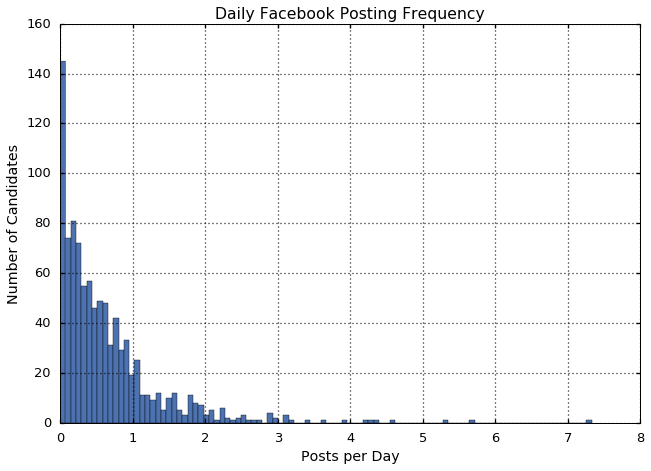

In [39]:
has_fb = cand_district[cand_district['hasCampFB']==1]
has_fb[has_fb['camp_fb_freq'] < 10]['camp_fb_freq'].hist(bins=100)
plt.title('Daily Facebook Posting Frequency')
plt.xlabel('Posts per Day')
plt.ylabel('Number of Candidates')

In [48]:
formula = 'camp_fb_freq ~ 1 + isSenate + isIncumbent + wonRace + is3rd + isRep +isDem + isFemale + abs_or_diff + age'
poly = smf.ols(formula=formula, data=cand_district).fit()
print(poly.summary())

                            OLS Regression Results                            
Dep. Variable:           camp_fb_freq   R-squared:                       0.155
Model:                            OLS   Adj. R-squared:                  0.145
Method:                 Least Squares   F-statistic:                     16.02
Date:                Tue, 18 Apr 2017   Prob (F-statistic):           2.91e-24
Time:                        20:23:47   Log-Likelihood:                -823.20
No. Observations:                 798   AIC:                             1666.
Df Residuals:                     788   BIC:                             1713.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
Intercept       0.8055      0.156      5.149      

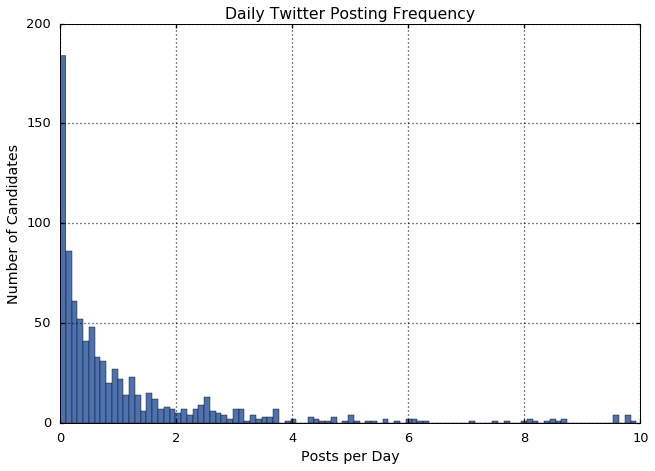

In [47]:
has_tw = cand_district[cand_district['hasCampTwitter']==1]
has_tw[has_tw['camp_tw_freq'] < 10]['camp_tw_freq'].hist(bins=100)
plt.title('Daily Twitter Posting Frequency')
plt.xlabel('Posts per Day')
plt.ylabel('Number of Candidates')

In [53]:
formula = 'camp_tw_freq ~ 1 + isSenate + isIncumbent + wonRace + is3rd + isRep +isDem + isFemale + abs_or_diff + age'
poly = smf.ols(formula=formula, data=cand_district).fit()
print(poly.summary())

                            OLS Regression Results                            
Dep. Variable:           camp_tw_freq   R-squared:                       0.136
Model:                            OLS   Adj. R-squared:                  0.126
Method:                 Least Squares   F-statistic:                     13.74
Date:                Tue, 18 Apr 2017   Prob (F-statistic):           1.20e-20
Time:                        21:04:51   Log-Likelihood:                -1542.9
No. Observations:                 798   AIC:                             3106.
Df Residuals:                     788   BIC:                             3153.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
Intercept       1.2477      0.385      3.237      

In [10]:
freq_camp_fb['day_of_year'] = abs(freq_camp_fb['days_before'] - 624) - 312
freq_camp_tw['day_of_year'] = abs(freq_camp_tw['days_before'] - 624) - 312

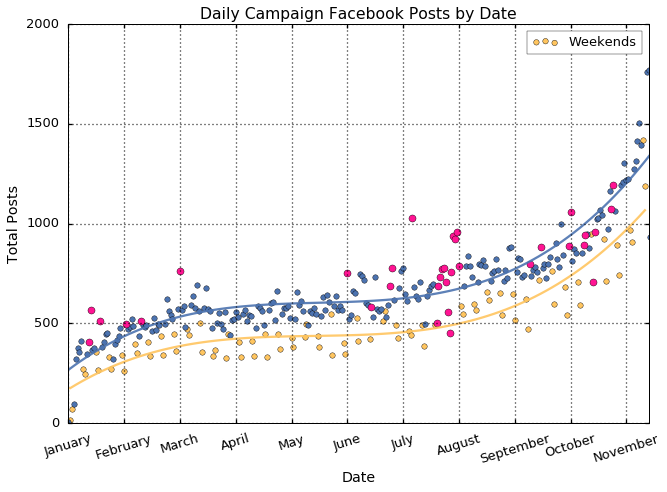

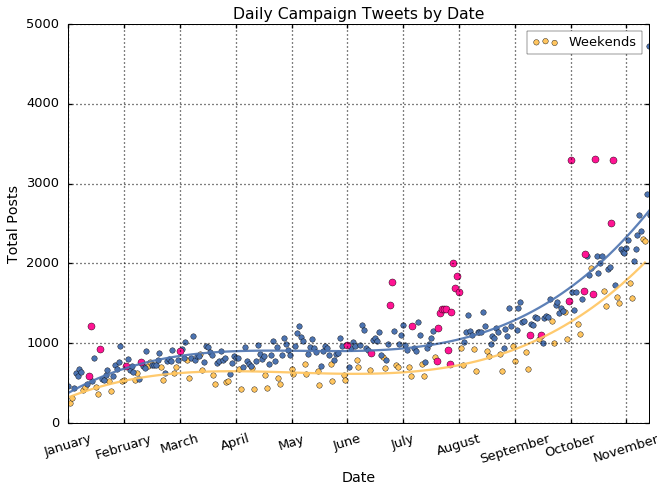

In [91]:
def n_regress(df, n, label, color='#47C027'):
    x = pd.DataFrame({'day_of_year': np.linspace(df.day_of_year.min(), df.day_of_year.max(), 100), 'eventDates':0}) 
    formula = 'cand_id ~ 1 + eventDates'
    for i in range(1,n+1):
        formula += ' + I(day_of_year ** ' + str(i) + ')'
    poly = smf.ols(formula=formula, data=df).fit()
    #print(label)
    #print(poly.summary())
    plt.plot(x.day_of_year, poly.predict(x), '-',c=color, alpha=0.9, label=label + ': n='+str(n)+ ' $R^2$=%.2f' % poly.rsquared)

def poly_regress(df, title, weekendN = 3, weekdayN=3, new_plot=False, use_events=True):
    events = df[df['eventDates']==1]
    dfWeekend = df[df['weekday'].isin([5,6])]
    dfWeek = df[df['weekday'].isin([0,1,2,3,4])]
    if new_plot:
        dfWeekend.plot(x='day_of_year', y='cand_id', c='#FFC55F', kind="scatter", title = title, grid=True,label="Weekends",s=30)
    else:
        plt.scatter(dfWeekend.day_of_year, dfWeekend.cand_id, c='#FFC55F',label="Weekends",s=30)
    plt.scatter(dfWeek.day_of_year, dfWeek.cand_id, c='#4C73B0',label="Weekdays",s=30)
    
    n_regress(dfWeek, weekdayN, "Weekdays",'#4C73B0')
    n_regress(dfWeekend, weekendN, "Weekends","#FFC55F")
    if use_events:
        plt.scatter(events.day_of_year, events.cand_id, c="#FF1493", s=50,label="Events and Holidays")
    plt.xlabel("Date")
    plt.ylabel("Total Posts")
    plt.ylim(0,)
    plt.xlim(0,312)
    plt.xticks(range(0,312,30), calendar.month_name[1:12], rotation=17)
    #plt.legend()
    
poly_regress(freq_camp_fb,"Daily Campaign Facebook Posts by Date", new_plot=True)
poly_regress(freq_camp_tw,"Daily Campaign Tweets by Date", new_plot=True)

In [322]:
def get_dates(df, cand_df, start_date, end_date, has_opponent=1):
    start = df[df['primary_date'] >= pd.to_datetime(start_date)]
    end = start[start['primary_date'] < pd.to_datetime(end_date)]
    end = end[end['primary_opponents'] == has_opponent]
    final = setup_post_df(end.groupby('just_date').count().reset_index())
    final['day_of_year'] = abs(final['days_before'] - 624) - 312
    cand_start = cand_df[cand_df['primary_date'] >= pd.to_datetime(start_date)]
    cand_end = cand_start[cand_start['primary_date'] < pd.to_datetime(end_date)]
    cand_end = cand_end[cand_end['primary_opponents'] == has_opponent]
    final['cand_id'] = final['cand_id'] / len(cand_end)
    print(len(cand_end))
    return final

def n_regress(df, n, label, color='#47C027'):
    x = pd.DataFrame({'day_of_year': np.linspace(df.day_of_year.min(), df.day_of_year.max(), 100)}) 
    formula = 'cand_id ~ 1'
    for i in range(1,n+1):
        formula += ' + I(day_of_year ** ' + str(i) + ')'
    poly = smf.ols(formula=formula, data=df).fit()
    #print(label)
    #print(poly.summary())
    plt.plot(x.day_of_year, poly.predict(x), '-',c=color, alpha=0.9, label=label + ': n='+str(n)+ ' $R^2$=%.2f' % poly.rsquared)

def poly_regress(df, title, n = 3, new_plot=False, c='y', start=1,end=312):
    if new_plot:
        df.plot(x='day_of_year', y='cand_id', c=c, kind="scatter", title = title, grid=True,s=30)
    else:
        plt.scatter(df.day_of_year, df.cand_id, c=c,s=30)
    
    #n_regress(df, n, title,c)
    plt.xlabel("Date")
    plt.ylabel("Daily Posts per Candidate")
    plt.ylim(0,)
    plt.xlim(0,45)
    ticks = [0,32, 61, 92, 122, 153, 183, 214, 245, 275, 306]
    plt.xticks(ticks, calendar.month_name[1:12], rotation=17)
    plt.axvspan(start, end, color='yellow', alpha=0.3)

def week(row):
    return row.week

In [323]:
march = get_dates(fb_cand_merge, cand_df, '2016-03-01', '2016-04-01')
april = get_dates(fb_cand_merge, cand_df, '2016-04-01', '2016-05-01')
may = get_dates(fb_cand_merge, cand_df, '2016-05-01', '2016-06-01')
june = get_dates(fb_cand_merge, cand_df, '2016-06-01', '2016-07-01')
august = get_dates(fb_cand_merge, cand_df, '2016-08-01', '2016-09-01')
september = get_dates(fb_cand_merge, cand_df, '2016-09-01', '2016-10-01')

march_no_opp = get_dates(fb_cand_merge, cand_df, '2016-03-01', '2016-04-01', has_opponent=0)
april_no_opp = get_dates(fb_cand_merge, cand_df, '2016-04-01', '2016-05-01', has_opponent=0)
may_no_opp = get_dates(fb_cand_merge, cand_df, '2016-05-01', '2016-06-01', has_opponent=0)
june_no_opp = get_dates(fb_cand_merge, cand_df, '2016-06-01', '2016-07-01', has_opponent=0)
august_no_opp = get_dates(fb_cand_merge, cand_df, '2016-08-01', '2016-09-01', has_opponent=0)
september_no_opp = get_dates(fb_cand_merge, cand_df, '2016-09-01', '2016-10-01', has_opponent=0)

76
29
52
164
131
7
157
44
41
214
186
29


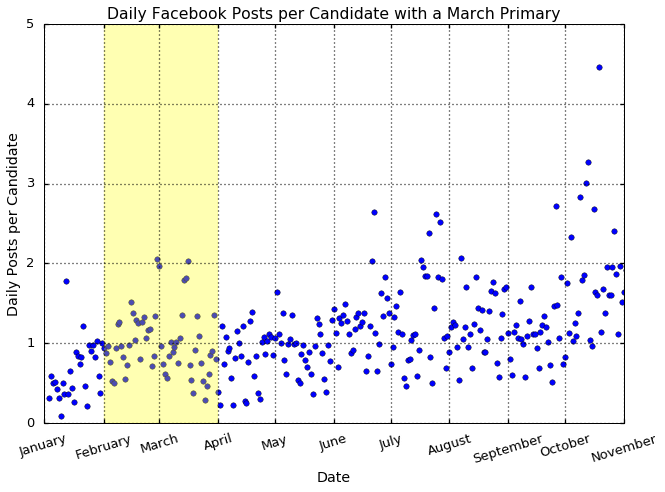

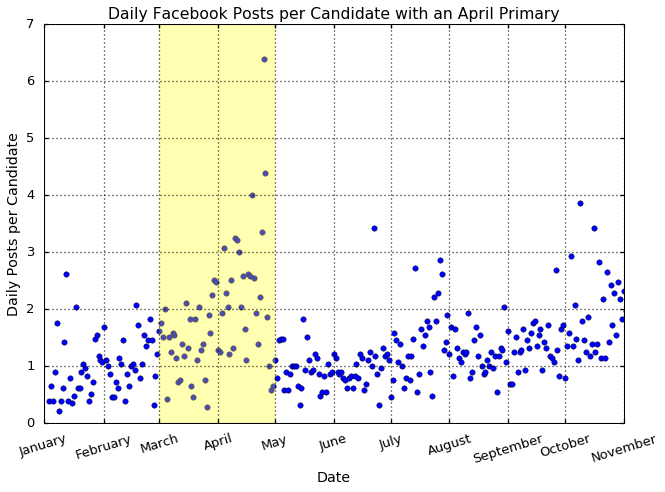

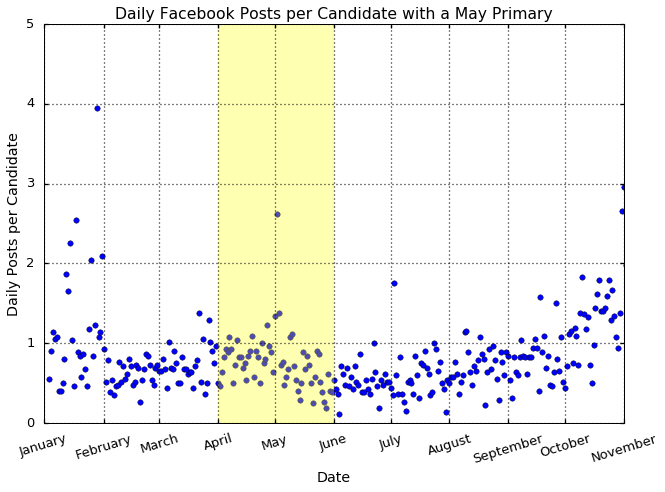

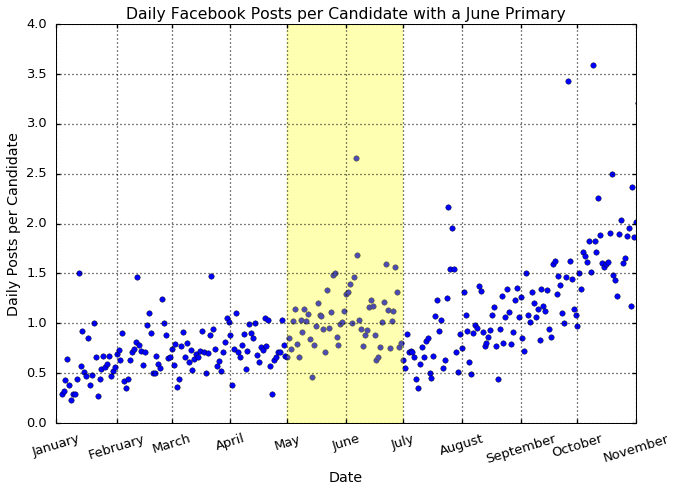

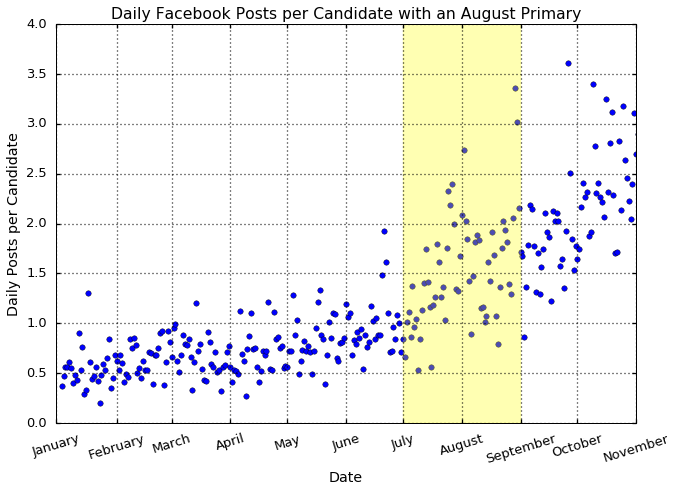

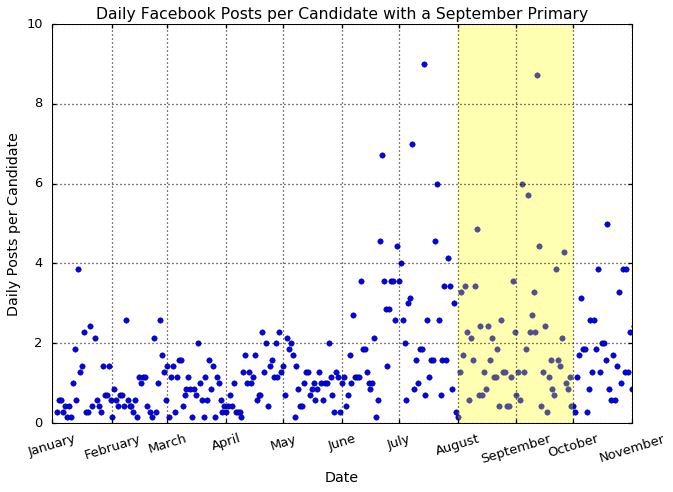

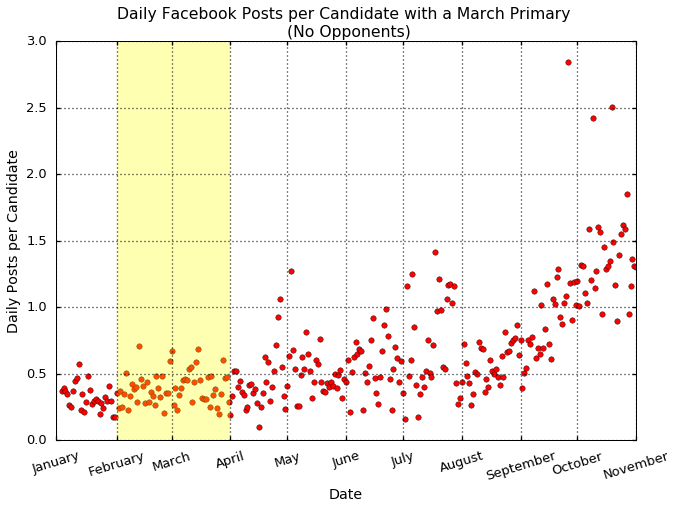

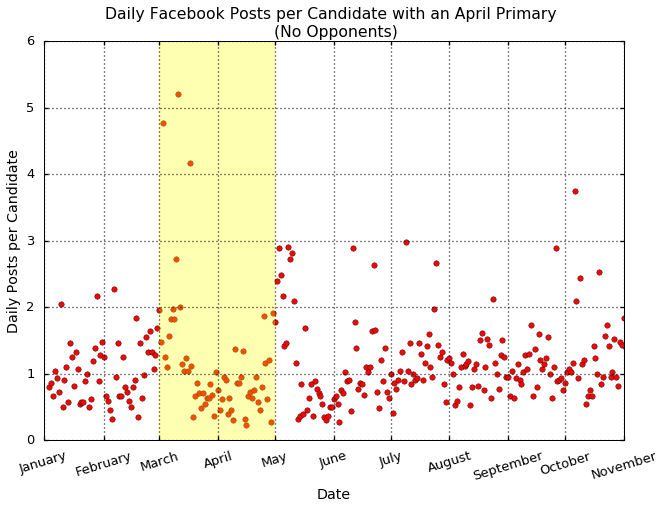

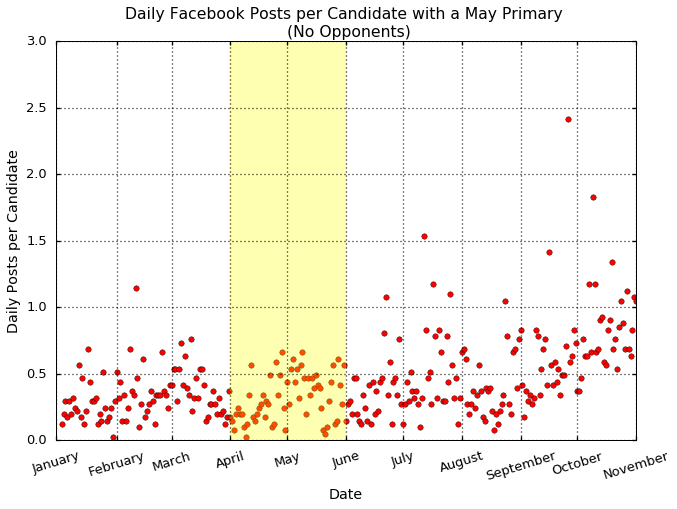

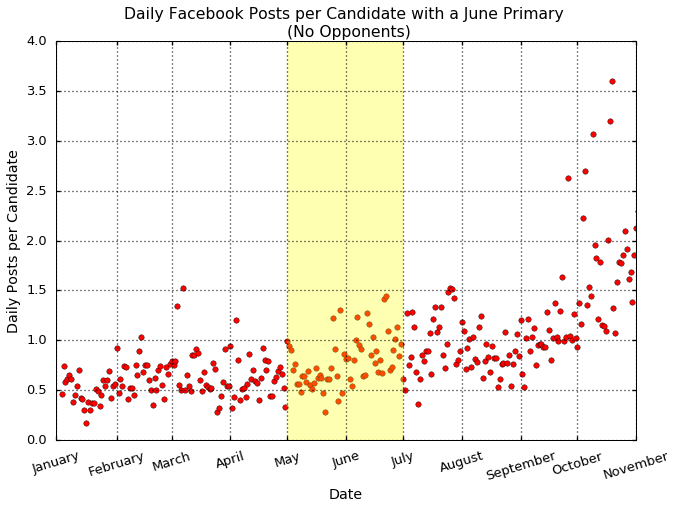

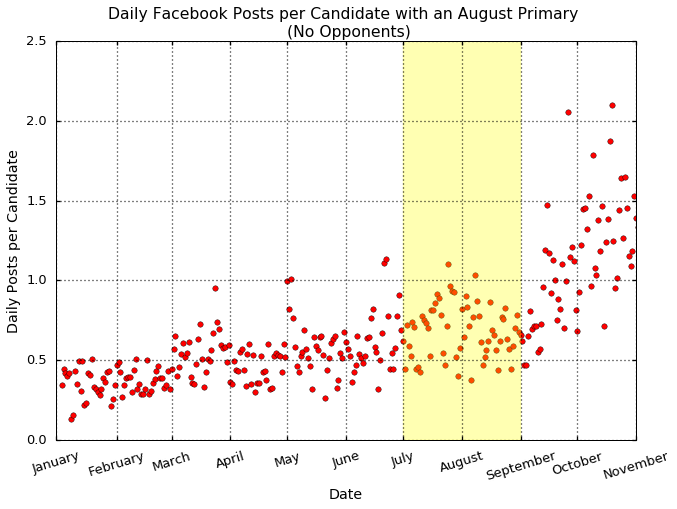

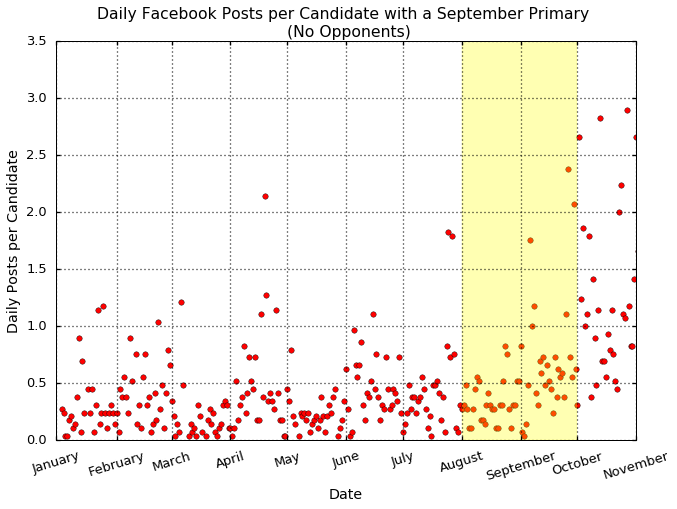

In [314]:
poly_regress(march,"Daily Facebook Posts per Candidate with a March Primary",new_plot=True, n=4, c='b', start = 32, end = 92)
poly_regress(april,"Daily Facebook Posts per Candidate with an April Primary",new_plot=True, n=4, c='b', start=61,end=122)
poly_regress(may,"Daily Facebook Posts per Candidate with a May Primary",new_plot=True, n=4, c='b', start=92, end=153)
poly_regress(june,"Daily Facebook Posts per Candidate with a June Primary",new_plot=True, n=4, c='b', start=122, end=183)
poly_regress(august,"Daily Facebook Posts per Candidate with an August Primary",new_plot=True, n=2, c='b', start=183, end=245)
poly_regress(september,"Daily Facebook Posts per Candidate with a September Primary",new_plot=True, n=2, c='b', start=214, end=275)

poly_regress(march_no_opp,"Daily Facebook Posts per Candidate with a March Primary \n (No Opponents)",new_plot=True, n=4, c='r', start=32, end=92)
poly_regress(april_no_opp,"Daily Facebook Posts per Candidate with an April Primary \n (No Opponents)",new_plot=True, n=4, c='r', start=61,end=122)
poly_regress(may_no_opp,"Daily Facebook Posts per Candidate with a May Primary \n (No Opponents)",new_plot=True, n=3, c='r', start=92, end=153)
poly_regress(june_no_opp,"Daily Facebook Posts per Candidate with a June Primary \n (No Opponents)",new_plot=True, n=3, c='r', start=122, end=183)
poly_regress(august_no_opp,"Daily Facebook Posts per Candidate with an August Primary \n (No Opponents)",new_plot=True, n=2, c='r', start=183, end=245)
poly_regress(september_no_opp,"Daily Facebook Posts per Candidate with a September Primary \n (No Opponents)",new_plot=True, n=2, c='r', start=214, end=275)

76
29
52
164
131
7
157
44
41
214
186
29


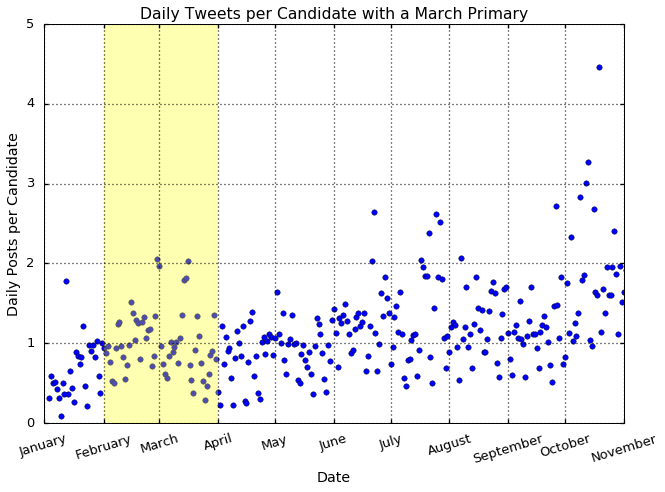

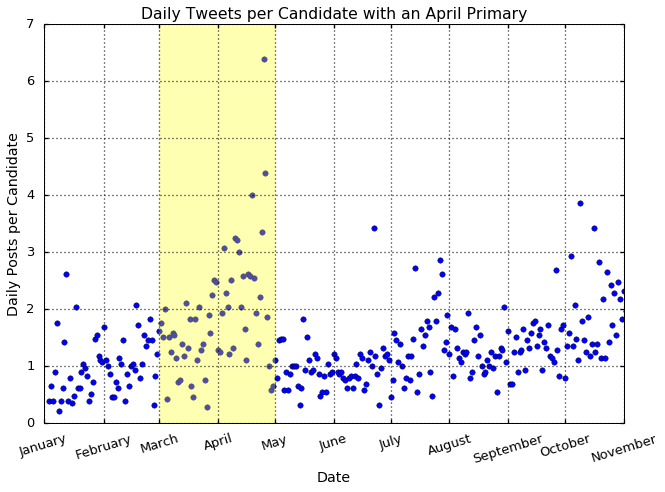

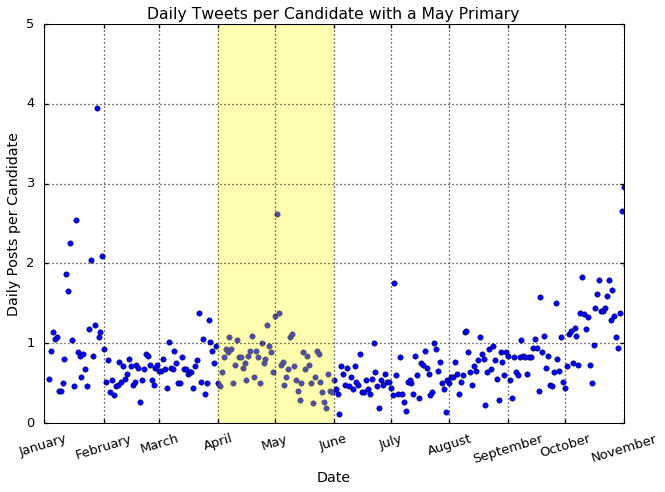

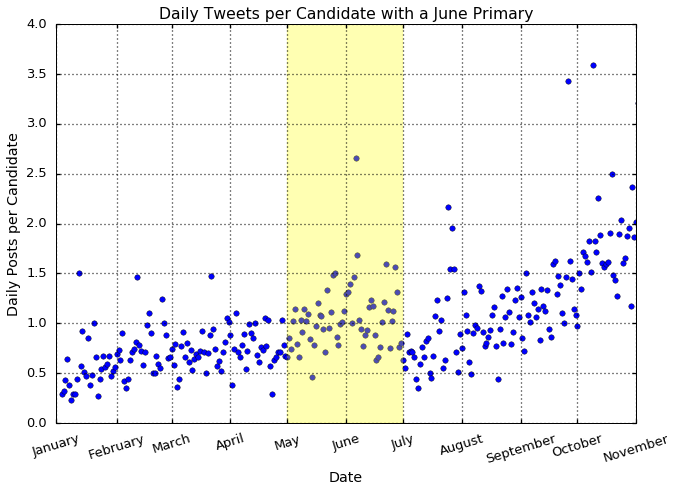

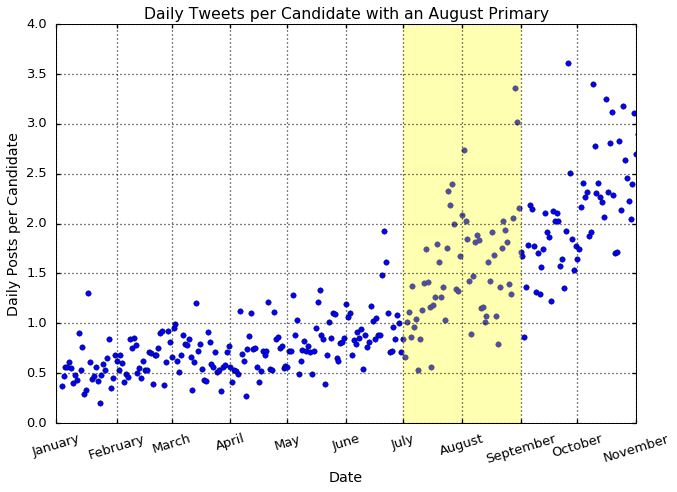

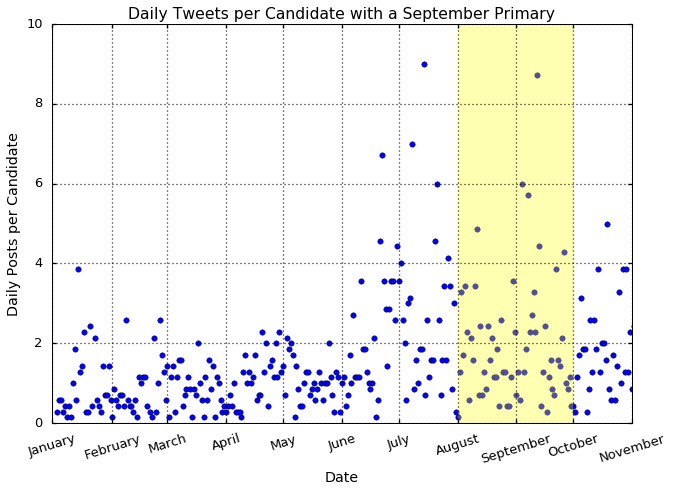

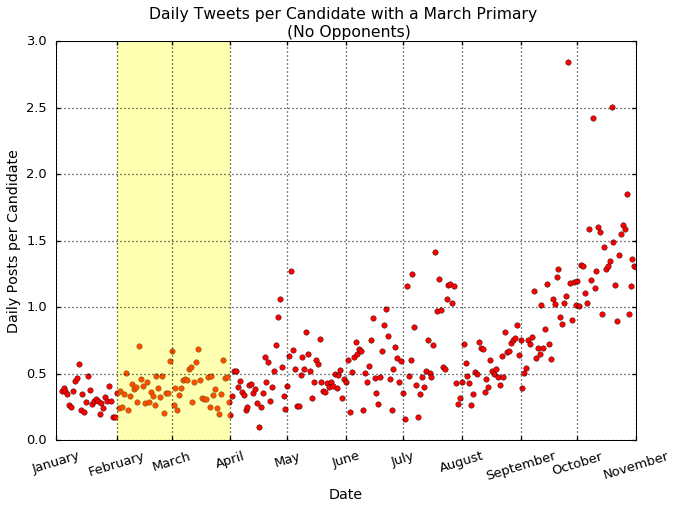

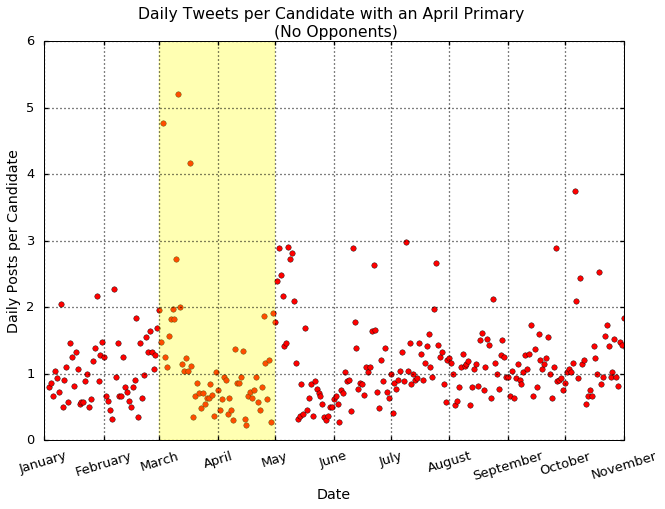

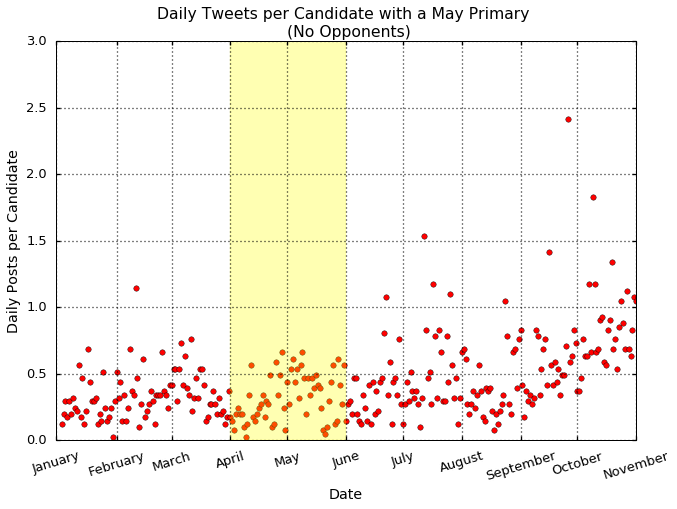

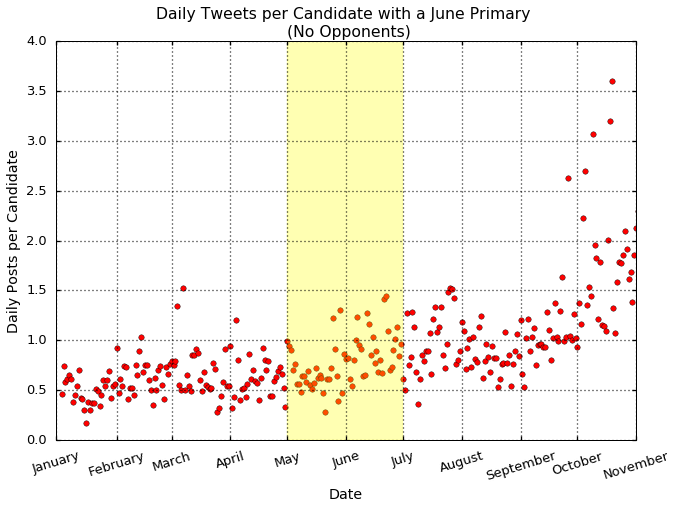

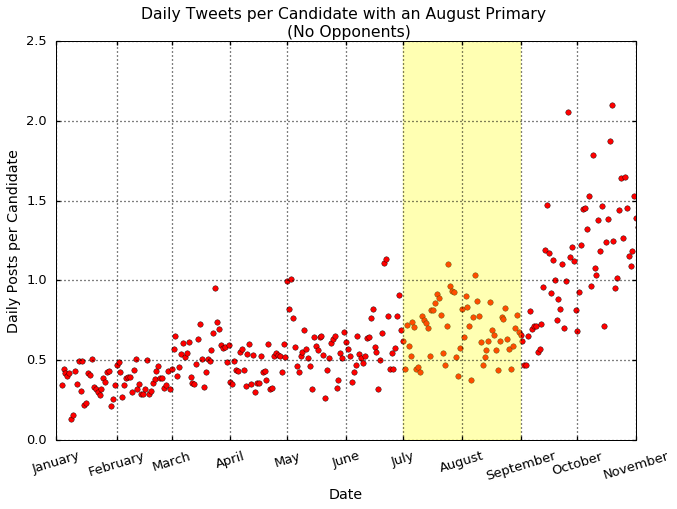

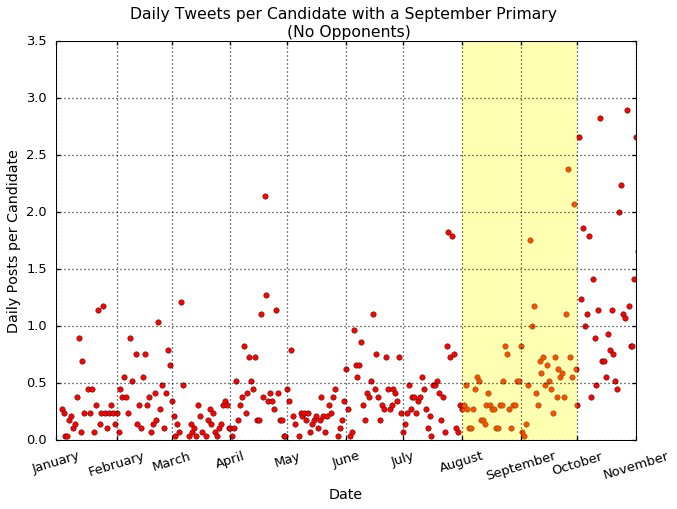

In [324]:
march = get_dates(tw_cand_merge, cand_df, '2016-03-01', '2016-04-01')
april = get_dates(tw_cand_merge, cand_df, '2016-04-01', '2016-05-01')
may = get_dates(tw_cand_merge, cand_df, '2016-05-01', '2016-06-01')
june = get_dates(tw_cand_merge, cand_df, '2016-06-01', '2016-07-01')
august = get_dates(tw_cand_merge, cand_df, '2016-08-01', '2016-09-01')
september = get_dates(tw_cand_merge, cand_df, '2016-09-01', '2016-10-01')

march_no_opp = get_dates(tw_cand_merge, cand_df, '2016-03-01', '2016-04-01', has_opponent=0)
april_no_opp = get_dates(tw_cand_merge, cand_df, '2016-04-01', '2016-05-01', has_opponent=0)
may_no_opp = get_dates(tw_cand_merge, cand_df, '2016-05-01', '2016-06-01', has_opponent=0)
june_no_opp = get_dates(tw_cand_merge, cand_df, '2016-06-01', '2016-07-01', has_opponent=0)
august_no_opp = get_dates(tw_cand_merge, cand_df, '2016-08-01', '2016-09-01', has_opponent=0)
september_no_opp = get_dates(tw_cand_merge, cand_df, '2016-09-01', '2016-10-01', has_opponent=0)

poly_regress(march,"Daily Tweets per Candidate with a March Primary",new_plot=True, n=4, c='b', start = 32, end = 92)
poly_regress(april,"Daily Tweets per Candidate with an April Primary",new_plot=True, n=4, c='b', start=61,end=122)
poly_regress(may,"Daily Tweets per Candidate with a May Primary",new_plot=True, n=4, c='b', start=92, end=153)
poly_regress(june,"Daily Tweets per Candidate with a June Primary",new_plot=True, n=4, c='b', start=122, end=183)
poly_regress(august,"Daily Tweets per Candidate with an August Primary",new_plot=True, n=2, c='b', start=183, end=245)
poly_regress(september,"Daily Tweets per Candidate with a September Primary",new_plot=True, n=2, c='b', start=214, end=275)

poly_regress(march_no_opp,"Daily Tweets per Candidate with a March Primary \n (No Opponents)",new_plot=True, n=4, c='r', start=32, end=92)
poly_regress(april_no_opp,"Daily Tweets per Candidate with an April Primary \n (No Opponents)",new_plot=True, n=4, c='r', start=61,end=122)
poly_regress(may_no_opp,"Daily Tweets per Candidate with a May Primary \n (No Opponents)",new_plot=True, n=3, c='r', start=92, end=153)
poly_regress(june_no_opp,"Daily Tweets per Candidate with a June Primary \n (No Opponents)",new_plot=True, n=3, c='r', start=122, end=183)
poly_regress(august_no_opp,"Daily Tweets per Candidate with an August Primary \n (No Opponents)",new_plot=True, n=2, c='r', start=183, end=245)
poly_regress(september_no_opp,"Daily Tweets per Candidate with a September Primary \n (No Opponents)",new_plot=True, n=2, c='r', start=214, end=275)

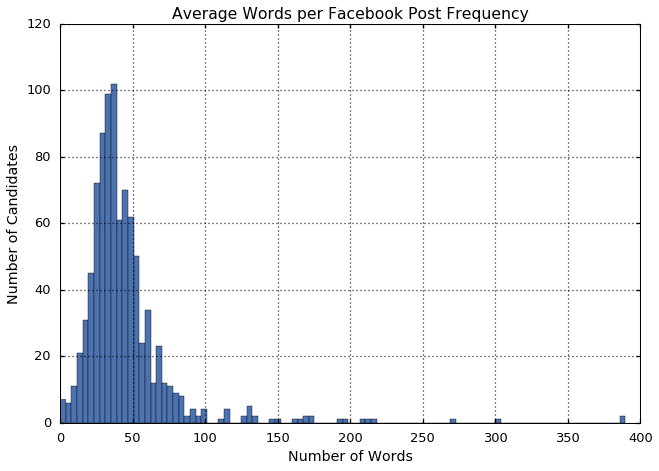

In [85]:
has_fb['words_camp_fb'].hist(bins=100)
plt.title('Average Words per Facebook Post Frequency')
plt.xlabel('Number of Words')
plt.ylabel('Number of Candidates')

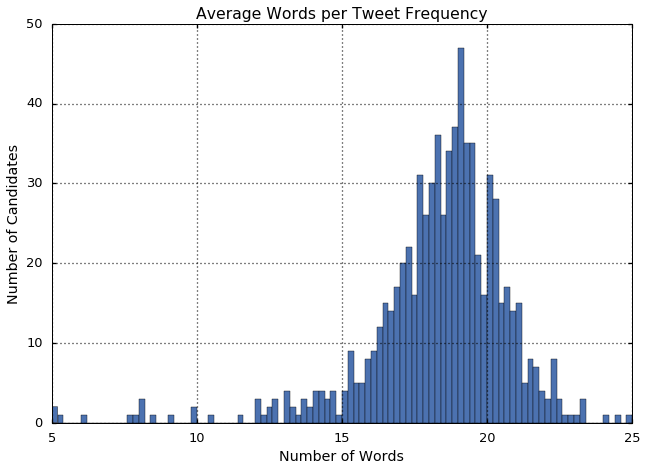

In [87]:
has_fb['words_camptw'].hist(bins=100)
plt.title('Average Words per Tweet Frequency')
plt.xlabel('Number of Words')
plt.ylabel('Number of Candidates')

In [54]:
formula = 'words_camp_fb ~ 1 + isSenate + isIncumbent + wonRace + is3rd + isRep +isDem + isFemale + abs_or_diff + age'
poly = smf.ols(formula=formula, data=cand_district).fit()
print(poly.summary())

                            OLS Regression Results                            
Dep. Variable:          words_camp_fb   R-squared:                       0.022
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     1.649
Date:                Tue, 18 Apr 2017   Prob (F-statistic):             0.0980
Time:                        21:34:30   Log-Likelihood:                -2960.7
No. Observations:                 661   AIC:                             5941.
Df Residuals:                     651   BIC:                             5986.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
Intercept      46.4090      5.821      7.972      

In [55]:
formula = 'words_camptw ~ 1 + isSenate + isIncumbent + wonRace + is3rd + isRep +isDem + isFemale + abs_or_diff + age'
poly = smf.ols(formula=formula, data=cand_district).fit()
print(poly.summary())

                            OLS Regression Results                            
Dep. Variable:           words_camptw   R-squared:                       0.107
Model:                            OLS   Adj. R-squared:                  0.094
Method:                 Least Squares   F-statistic:                     7.889
Date:                Tue, 18 Apr 2017   Prob (F-statistic):           4.81e-11
Time:                        21:40:17   Log-Likelihood:                -1336.9
No. Observations:                 602   AIC:                             2694.
Df Residuals:                     592   BIC:                             2738.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
Intercept      16.7286      0.618     27.065      

In [199]:
def n_regress(df, n, label, color='#47C027'):
    x = pd.DataFrame({'day_of_year': np.linspace(df.day_of_year.min(), df.day_of_year.max(), 100), 'eventDates':0}) 
    formula = 'num_words ~ 1 + eventDates'
    for i in range(1,n+1):
        formula += ' + I(day_of_year ** ' + str(i) + ')'
    poly = smf.ols(formula=formula, data=df).fit()
    print(label)
    print(poly.summary())
    plt.plot(x.day_of_year, poly.predict(x), '-',c=color, alpha=0.9, label=label + ': n='+str(n)+ ' $R^2$=%.2f' % poly.rsquared)

def poly_regress_word(df, title, session = False, weekendN = 1, weekdayN=1, ys=0,ye=100):
    events = df[df['eventDates']==1]
    dfWeekend = df[df['weekday'].isin([5,6])]
    dfWeek = df[df['weekday'].isin([0,1,2,3,4])]
    dfWeekend.plot(x='day_of_year', y='num_words', c='#FFC55F', kind="scatter", title = title, grid=True,label="Weekends",s=30)
    
    plt.scatter(dfWeek.day_of_year, dfWeek.num_words, c='#4C73B0',label="Weekdays",s=30)
    
    n_regress(dfWeek, weekdayN, "Weekdays",'#4C73B0')
    n_regress(dfWeekend, weekendN, "Weekends","#FFC55F")
    
    plt.scatter(events.day_of_year, events.num_words, c="#FF1493", s=50,label="Events and Holidays")
    
    plt.xlabel("Date")
    plt.ylabel("Total Posts")
    plt.ylim(ys,ye)
    plt.xlim(0,312)
    plt.xticks(range(0,312,30), calendar.month_name[1:12], rotation=17)
    print(plt.xticks())
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [194]:
mean_camp_fb['day_of_year'] = abs(mean_camp_fb['days_before'] - 624) - 312
mean_camp_tw['day_of_year'] = abs(mean_camp_tw['days_before'] - 624) - 312

Weekdays
                            OLS Regression Results                            
Dep. Variable:              num_words   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.8512
Date:                Mon, 17 Apr 2017   Prob (F-statistic):              0.428
Time:                        18:42:01   Log-Likelihood:                -715.83
No. Observations:                 224   AIC:                             1438.
Df Residuals:                     221   BIC:                             1448.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------------
Intercept              45

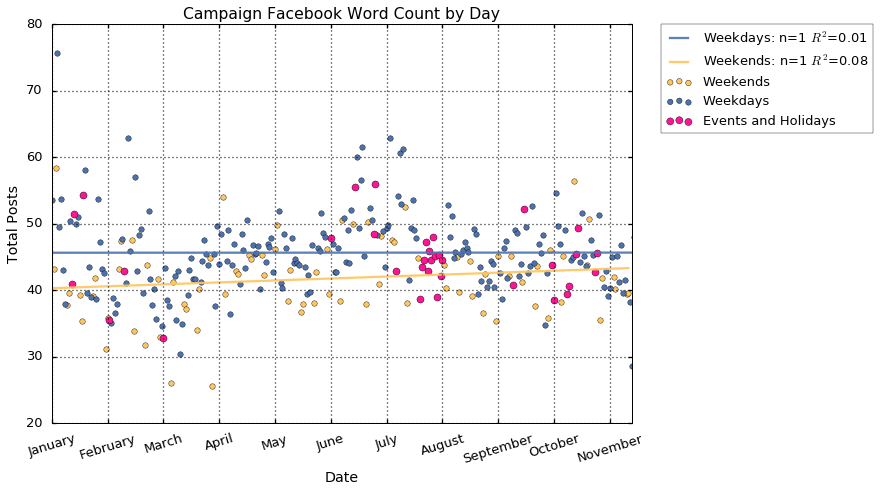

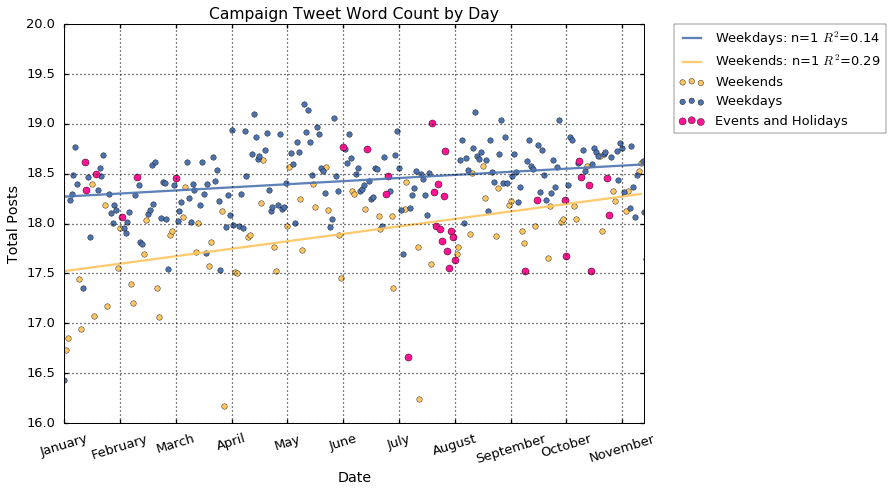

In [200]:
poly_regress_word(mean_camp_fb, "Campaign Facebook Word Count by Day", ys=20,ye=80)
poly_regress_word(mean_camp_tw, "Campaign Tweet Word Count by Day",ys=16,ye=20)

In [19]:
cand_df['available_days'] = (cand_df['primary_date'] - pd.to_datetime('2016-01-01')).dt.days

In [30]:
week_days = [1,0,6,5,4,3,2]
def fix_weekday(days_before):
    week_day = week_days[days_before % 7]
    return week_day

def available_days(day, has_opp):
    day_cands = cand_df[cand_df['available_days'] >= day]
    opp_cands = day_cands[day_cands['primary_opponents'] == has_opp]
    cands_available = len(opp_cands)
    return cands_available

def fix_primary_df(df, has_opp, marker='fb_id'):
    before_primary = df[df['days_before_primary'] >= 0]
    before_primary = before_primary[before_primary['primary_date'] != pd.to_datetime('2016-11-08')]
    opp = before_primary[before_primary['primary_opponents'] == has_opp].groupby(['days_before_primary','cand_id']).count().reset_index()
    opp_final = opp.reset_index().groupby('days_before_primary').sum().reset_index()[['days_before_primary',marker]]
    opp_final['index'] = opp_final[marker]

    opp_final['available_cands'] = opp_final['days_before_primary'].apply(available_days, args=(has_opp,))
    opp_final['ratio'] = opp_final['index'] / opp_final['available_cands']
    
    opp_final['primary_weekday'] = opp_final['days_before_primary'].apply(fix_weekday)
    
    opp_Week = opp_final[opp_final['primary_weekday'].isin([0,1,2,3,4])]
    opp_Weekend = opp_final[opp_final['primary_weekday'].isin([5, 6])]
        
    return opp_Week, opp_Weekend

def n_regress(df, n, label, color='#47C027'):
    x = pd.DataFrame({'days_before_primary': np.linspace(df.days_before_primary.min(), df.days_before_primary.max(), 100)}) 
    formula = 'ratio ~ 1'
    for i in range(1,n+1):
        formula += ' + I(days_before_primary ** ' + str(i) + ')'
    poly = smf.ols(formula=formula, data=df).fit()
    print(label)
    print(poly.summary())
    plt.plot(x.days_before_primary, poly.predict(x), '-',c=color, alpha=0.9, label=label + ': n='+str(n)+ ' $R^2$=%.2f' % poly.rsquared)

Weekends with Opponent(s)
                            OLS Regression Results                            
Dep. Variable:                  ratio   R-squared:                       0.853
Model:                            OLS   Adj. R-squared:                  0.846
Method:                 Least Squares   F-statistic:                     129.2
Date:                Thu, 20 Apr 2017   Prob (F-statistic):           8.42e-28
Time:                        13:09:29   Log-Likelihood:                 86.088
No. Observations:                  71   AIC:                            -164.2
Df Residuals:                      67   BIC:                            -155.1
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------------

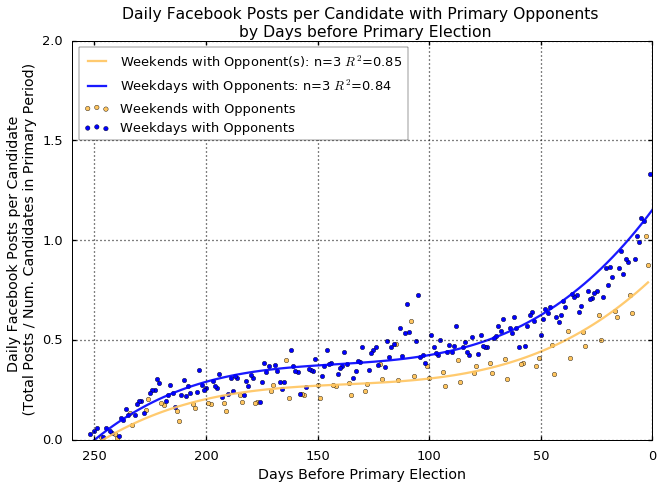

In [31]:
has_opp_Week, has_opp_Weekend = fix_primary_df(fb_cand_merge, 1)
has_opp_Weekend.plot(x='days_before_primary', y='ratio', c='#FFC55F', kind='scatter', legend = True, grid=True, label="Weekends with Opponents")
n_regress(has_opp_Weekend, 3,"Weekends with Opponent(s)", color='#FFC55F')

plt.scatter(x=has_opp_Week.days_before_primary, y=has_opp_Week.ratio, c='b', label='Weekdays with Opponents')
n_regress(has_opp_Week, 3,"Weekdays with Opponents", color='b')

plt.xlim(260,0)
plt.ylim(0,2)
plt.title('Daily Facebook Posts per Candidate with Primary Opponents \n by Days before Primary Election')
plt.ylabel('Daily Facebook Posts per Candidate \n (Total Posts / Num. Candidates in Primary Period)')
plt.xlabel('Days Before Primary Election')
plt.legend(loc=2)

Weekdays without Opponents
                            OLS Regression Results                            
Dep. Variable:                  ratio   R-squared:                       0.046
Model:                            OLS   Adj. R-squared:                  0.041
Method:                 Least Squares   F-statistic:                     8.653
Date:                Thu, 20 Apr 2017   Prob (F-statistic):            0.00370
Time:                        13:10:37   Log-Likelihood:                 196.40
No. Observations:                 181   AIC:                            -388.8
Df Residuals:                     179   BIC:                            -382.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------------

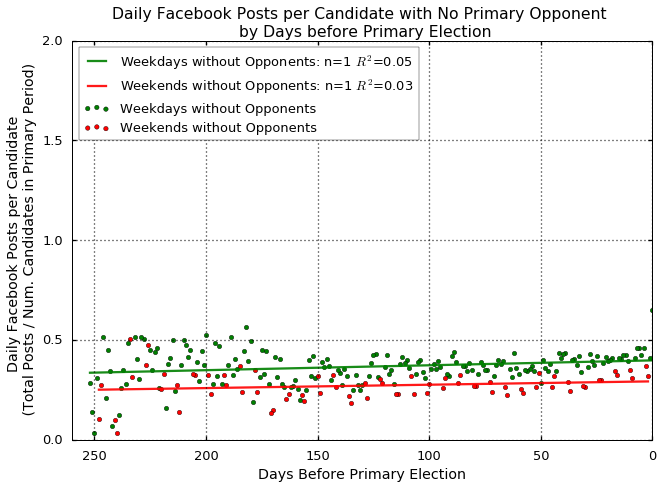

In [33]:
no_opp_Week, no_opp_Weekend = fix_primary_df(fb_cand_merge, 0)

no_opp_Week.plot(x='days_before_primary', y='ratio', c='g', kind='scatter',  label = "Weekdays without Opponents", grid=True)
n_regress(no_opp_Week, 1,"Weekdays without Opponents", color='g')

plt.scatter(x=no_opp_Weekend.days_before_primary, y=no_opp_Weekend.ratio, c='r', label="Weekends without Opponents")
n_regress(no_opp_Weekend, 1,"Weekends without Opponents", color='r')
plt.xlim(260,0)
plt.ylim(0,2)
plt.title('Daily Facebook Posts per Candidate with No Primary Opponent \n by Days before Primary Election')
plt.ylabel('Daily Facebook Posts per Candidate \n (Total Posts / Num. Candidates in Primary Period)')
plt.xlabel('Days Before Primary Election')
plt.legend(loc=2)

Weekends with Opponents
                            OLS Regression Results                            
Dep. Variable:                  ratio   R-squared:                       0.731
Model:                            OLS   Adj. R-squared:                  0.720
Method:                 Least Squares   F-statistic:                     62.59
Date:                Mon, 17 Apr 2017   Prob (F-statistic):           1.18e-19
Time:                        18:22:29   Log-Likelihood:                 48.160
No. Observations:                  73   AIC:                            -88.32
Df Residuals:                      69   BIC:                            -79.16
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------------

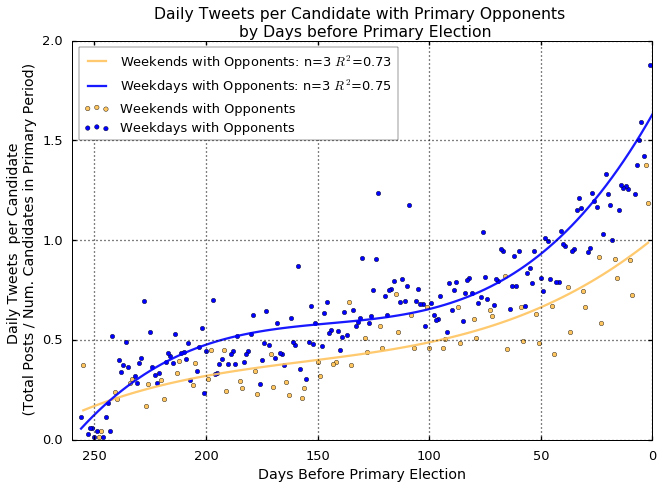

In [191]:
has_opp_Week, has_opp_Weekend = fix_primary_df(tw_cand_merge, 1, marker='tweet_id')
has_opp_Weekend.plot(x='days_before_primary', y='ratio', c='#FFC55F', kind='scatter', label = "Weekends with Opponents", grid=True)
n_regress(has_opp_Weekend, 3,"Weekends with Opponents", color='#FFC55F')

plt.scatter(x=has_opp_Week.days_before_primary, y=has_opp_Week.ratio, c='b', label='Weekdays with Opponents')
n_regress(has_opp_Week, 3,"Weekdays with Opponents", color='b')

plt.title('Daily Tweets per Candidate with Primary Opponents \n by Days before Primary Election')
plt.ylabel('Daily Tweets  per Candidate \n (Total Posts / Num. Candidates in Primary Period)')
plt.xlabel('Days Before Primary Election')
plt.xlim(260,0)
plt.ylim(0,2)
plt.legend(loc=2)

Weekdays without Opponents
                            OLS Regression Results                            
Dep. Variable:                  ratio   R-squared:                       0.544
Model:                            OLS   Adj. R-squared:                  0.541
Method:                 Least Squares   F-statistic:                     215.7
Date:                Mon, 17 Apr 2017   Prob (F-statistic):           1.16e-32
Time:                        18:38:26   Log-Likelihood:                 135.16
No. Observations:                 183   AIC:                            -266.3
Df Residuals:                     181   BIC:                            -259.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------------

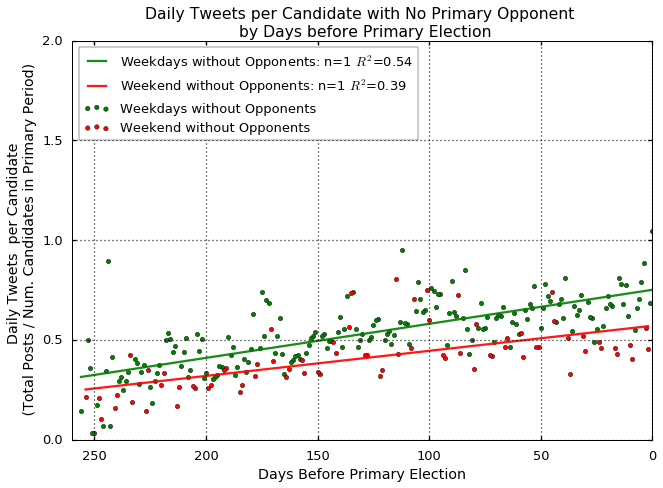

In [198]:
no_opp_Week, no_opp_Weekend = fix_primary_df(tw_cand_merge, 0, marker='tweet_id')
no_opp_Week.plot(x='days_before_primary', y='ratio', c='g', kind='scatter', label = "Weekdays without Opponents", grid=True)
n_regress(no_opp_Week, 1,"Weekdays without Opponents", color='g')


plt.scatter(x=no_opp_Weekend.days_before_primary, y=no_opp_Weekend.ratio, c='r', label="Weekend without Opponents")
n_regress(no_opp_Weekend, 1,"Weekend without Opponents", color='r')

plt.title('Daily Tweets per Candidate with No Primary Opponent \n by Days before Primary Election')
plt.ylabel('Daily Tweets  per Candidate \n (Total Posts / Num. Candidates in Primary Period)')
plt.xlabel('Days Before Primary Election')
plt.xlim(260,0)
plt.ylim(0,2)
plt.legend(loc=2)

In [13]:
incumbent_fb = fb_cand_merge[fb_cand_merge['isIncumbent_x'] == 1]
pd.crosstab(incumbent_fb.status_type, incumbent_fb.isGovernmentAcc, margins=True)#, normalize='columns').apply(lambda r: r*100)

isGovernmentAcc,0,All
status_type,,
album,1,1
event,1216,1216
link,27535,27535
music,8,8
note,25,25
photo,28205,28205
status,4651,4651
video,6669,6669
All,68310,68310


In [12]:
challenger_fb = fb_cand_merge[fb_cand_merge['isIncumbent_x'] == 0]
pd.crosstab(challenger_fb.status_type, challenger_fb.isGovernmentAcc, margins=True)

isGovernmentAcc,0,All
status_type,,
event,5336,5336
link,42153,42153
music,12,12
note,70,70
photo,56052,56052
status,11817,11817
video,16271,16271
All,131711,131711


In [19]:
def media_tabs(df, var, target):
    var_df = df[df[var] == target]
    tab = pd.crosstab(var_df.status_type, var_df.isGovernmentAcc, margins=True, normalize='columns').apply(lambda r: r*100)
    tab_full = pd.crosstab(var_df.status_type, var_df.isGovernmentAcc, margins=True)
    #observed = pd.crosstab(df[var], df.status_type)
    #chi = stats.chi2_contingency(observed=observed)
    #print(observed)
    #expected = pd.DataFrame(chi[3])
    #print(expected)
    print(tab)
    print(tab_full)

In [20]:
media_tabs(fb_cand_merge, 'isIncumbent_x', 0)

isGovernmentAcc          0        All
status_type                          
event             4.051294   4.051294
link             32.004161  32.004161
music             0.009111   0.009111
note              0.053147   0.053147
photo            42.556810  42.556810
status            8.971916   8.971916
video            12.353562  12.353562
isGovernmentAcc       0     All
status_type                    
event              5336    5336
link              42153   42153
music                12      12
note                 70      70
photo             56052   56052
status            11817   11817
video             16271   16271
All              131711  131711


In [21]:
media_tabs(fb_cand_merge, 'isSenate', 0)

isGovernmentAcc          0        All
status_type                          
album             0.000636   0.000636
event             3.612396   3.612396
link             34.149802  34.149802
music             0.010816   0.010816
note              0.043262   0.043262
photo            44.947545  44.947545
status            8.112940   8.112940
video             9.122604   9.122604
isGovernmentAcc       0     All
status_type                    
album                 1       1
event              5678    5678
link              53677   53677
music                17      17
note                 68      68
photo             70649   70649
status            12752   12752
video             14339   14339
All              157181  157181


In [22]:
media_tabs(fb_cand_merge, 'isSenate', 1)

isGovernmentAcc          0        All
status_type                          
event             2.040149   2.040149
link             37.373950  37.373950
music             0.007003   0.007003
note              0.063025   0.063025
photo            31.764706  31.764706
status            8.674136   8.674136
video            20.077031  20.077031
isGovernmentAcc      0    All
status_type                  
event              874    874
link             16011  16011
music                3      3
note                27     27
photo            13608  13608
status            3716   3716
video             8601   8601
All              42840  42840


In [24]:
media_tabs(fb_cand_merge, 'wonRace_x', 0)

isGovernmentAcc          0        All
status_type                          
event             4.416285   4.416285
link             31.847481  31.847481
music             0.007903   0.007903
note              0.043908   0.043908
photo            41.264029  41.264029
status            9.465725   9.465725
video            12.954669  12.954669
isGovernmentAcc       0     All
status_type                    
event              5029    5029
link              36266   36266
music                 9       9
note                 50      50
photo             46989   46989
status            10779   10779
video             14752   14752
All              113874  113874


In [23]:
media_tabs(fb_cand_merge, 'wonRace_x', 1)

isGovernmentAcc          0        All
status_type                          
album             0.001207   0.001207
event             1.793603   1.793603
link             39.278214  39.278214
music             0.013277   0.013277
note              0.051901   0.051901
photo            43.000604  43.000604
status            6.362100   6.362100
video             9.499095   9.499095
isGovernmentAcc      0    All
status_type                  
album                1      1
event             1486   1486
link             32542  32542
music               11     11
note                43     43
photo            35626  35626
status            5271   5271
video             7870   7870
All              82850  82850


In [25]:
media_tabs(fb_cand_merge, 'is3rd_x', 0)

isGovernmentAcc          0        All
status_type                          
album             0.000598   0.000598
event             3.330345   3.330345
link             35.501374  35.501374
music             0.010757   0.010757
note              0.050795   0.050795
photo            43.670372  43.670372
status            7.787738   7.787738
video             9.648022   9.648022
isGovernmentAcc       0     All
status_type                    
album                 1       1
event              5573    5573
link              59408   59408
music                18      18
note                 85      85
photo             73078   73078
status            13032   13032
video             16145   16145
All              167340  167340


In [26]:
media_tabs(fb_cand_merge, 'is3rd_x', 1)

isGovernmentAcc          0        All
status_type                          
event             2.995624   2.995624
link             31.455586  31.455586
music             0.006120   0.006120
note              0.030599   0.030599
photo            34.206420  34.206420
status           10.513754  10.513754
video            20.791897  20.791897
isGovernmentAcc      0    All
status_type                  
event              979    979
link             10280  10280
music                2      2
note                10     10
photo            11179  11179
status            3436   3436
video             6795   6795
All              32681  32681


In [27]:
media_tabs(fb_cand_merge, 'isRep_x', 1)

isGovernmentAcc          0        All
status_type                          
album             0.001208   0.001208
event             2.337775   2.337775
link             35.407329  35.407329
music             0.016914   0.016914
note              0.018122   0.018122
photo            43.704921  43.704921
status            7.019367   7.019367
video            11.494364  11.494364
isGovernmentAcc      0    All
status_type                  
album                1      1
event             1935   1935
link             29307  29307
music               14     14
note                15     15
photo            36175  36175
status            5810   5810
video             9514   9514
All              82771  82771


In [28]:
media_tabs(fb_cand_merge, 'isDem_x', 1)

isGovernmentAcc          0        All
status_type                          
event             4.301813   4.301813
link             35.593421  35.593421
music             0.004730   0.004730
note              0.082773   0.082773
photo            43.636557  43.636557
status            8.539772   8.539772
video             7.840935   7.840935
isGovernmentAcc      0    All
status_type                  
event             3638   3638
link             30101  30101
music                4      4
note                70     70
photo            36903  36903
status            7222   7222
video             6631   6631
All              84569  84569


In [30]:
media_tabs(fb_cand_merge, 'isFemale_x', 1)

isGovernmentAcc          0        All
status_type                          
album             0.002367   0.002367
event             3.932199   3.932199
link             35.704647  35.704647
music             0.009469   0.009469
note              0.037878   0.037878
photo            42.932222  42.932222
status            8.692976   8.692976
video             8.688241   8.688241
isGovernmentAcc      0    All
status_type                  
album                1      1
event             1661   1661
link             15082  15082
music                4      4
note                16     16
photo            18135  18135
status            3672   3672
video             3670   3670
All              42241  42241


In [29]:
media_tabs(fb_cand_merge, 'isFemale_x', 0)

isGovernmentAcc          0        All
status_type                          
event             3.099886   3.099886
link             34.608949  34.608949
music             0.010141   0.010141
note              0.050070   0.050070
photo            41.907720  41.907720
status            8.110027   8.110027
video            12.213208  12.213208
isGovernmentAcc       0     All
status_type                    
event              4891    4891
link              54606   54606
music                16      16
note                 79      79
photo             66122   66122
status            12796   12796
video             19270   19270
All              157780  157780


In [29]:
major_chal = challenger_fb[challenger_fb['is3rd'] == 0]
pd.crosstab(major_chal.status_type, major_chal.account, normalize='columns', margins=True).apply(lambda r: r*100)

account,Campaign,All
status_type,,
event,4.399677,4.399677
link,32.185196,32.185196
music,0.010098,0.010098
note,0.060588,0.060588
photo,45.312532,45.312532
status,8.463092,8.463092
video,9.568818,9.568818


In [30]:
third_chal = challenger_fb[challenger_fb['is3rd'] == 1]
pd.crosstab(third_chal.status_type, third_chal.account, normalize='columns', margins=True).apply(lambda r: r*100)

account,Campaign,All
status_type,,
event,2.995624,2.995624
link,31.455586,31.455586
music,0.006120,0.006120
note,0.030599,0.030599
photo,34.206420,34.206420
status,10.513754,10.513754
video,20.791897,20.791897


In [32]:
rep_fb = fb_cand_merge[fb_cand_merge['isRep'] == 1]
pd.crosstab(rep_fb.status_type, rep_fb.account, normalize='columns', margins=True).apply(lambda r: r*100)

account,Campaign,Government,All
status_type,,,
album,0.001208,0.000000,0.000615
event,2.337775,0.414584,1.393518
link,35.407329,43.175641,39.221450
music,0.016914,0.031313,0.023984
note,0.018122,0.005010,0.011684
photo,43.704921,39.386766,41.584773
status,7.019367,5.697717,6.370457
video,11.494364,11.288969,11.393518


In [33]:
dem_fb = fb_cand_merge[fb_cand_merge['isDem'] == 1]
pd.crosstab(dem_fb.status_type, dem_fb.account, normalize='columns', margins=True).apply(lambda r: r*100)

account,Campaign,Government,All
status_type,,,
event,4.301813,1.120679,3.107117
link,35.593421,39.396799,37.021804
music,0.004730,0.009831,0.006645
note,0.082773,0.102237,0.090083
photo,43.636557,43.777280,43.689406
status,8.539772,6.106720,7.626024
video,7.840935,9.486454,8.458920


In [7]:
def find_top_n_words(posts, n):
    phrase_dict = {}
    counter = 0
    for post in posts['message']:
        counter += 1
        if type(post) == str:
            tokens = word_tokenize(post)
            if n == 1:
                filtered = [word.lower() for word in tokens if word not in stopwords.words('english') and word not in string.punctuation and word not in ["n't","''"]]
            else:
                 filtered = [word.lower() for word in tokens]
            for start_word_index in range(len(filtered)):
                if len(filtered[start_word_index:]) >= n:
                    phrase = filtered[start_word_index : start_word_index + n]
                    phrase_formatted = ""
                    for word in phrase:
                        if word != phrase[0] and word[0] not in [".","'","!",","] and phrase_formatted[-1] not in string.punctuation:
                            phrase_formatted += " "
                        phrase_formatted += word
                    if phrase_formatted not in phrase_dict:
                        phrase_dict[phrase_formatted] = 0
                    phrase_dict[phrase_formatted] += 1
    phrase_dict = sorted(phrase_dict.items(), key=lambda x: x[1], reverse = True)
    return phrase_dict

print(find_top_n_words(camp_fb_df, 1))

KeyboardInterrupt: 

In [23]:
import os
source = '/Users/michaelvasiliou/Documents/Coding/BA Thesis/social_data/Vocabs/'
vocab_dictionary = {}
for root, dirs, filenames in os.walk(source):
    for f in filenames:
        if f[-7:] == '_unique':
            fullpath = os.path.join(root, f)
            cand_id = f.split('_')[0]
            with open(fullpath) as f:
                for i, l in enumerate(f):
                    pass
                vocab_size = i - 1
            page = fullpath.split('/')[8]
            if cand_id not in vocab_dictionary:
                vocab_dictionary[cand_id] = {}
            vocab_dictionary[cand_id][page] = vocab_size
print(vocab_dictionary)

{'287': {'camp_fb': 1167}, '668': {'gov_tweet': 4279, 'gov_fb': 2620}, '105': {'camp_fb': 845, 'camp_tweet': 197}, '618': {'camp_fb': 489, 'gov_tweet': 867, 'gov_fb': 863, 'camp_tweet': 881}, '833': {'camp_fb': 775, 'gov_tweet': 552, 'gov_fb': 2063, 'camp_tweet': 19}, '592': {'camp_fb': 2615, 'gov_tweet': 3327, 'gov_fb': 1906, 'camp_tweet': 2109}, '981': {'camp_fb': 1764}, '314': {'camp_fb': 2078, 'camp_tweet': 1669}, '154': {'camp_fb': 386}, '820': {'camp_fb': 1169, 'gov_tweet': 2288, 'gov_fb': 2033, 'camp_tweet': 1147}, '117': {'camp_fb': 1288, 'camp_tweet': 592}, '759': {'camp_fb': 941, 'gov_tweet': 2139, 'gov_fb': 3393, 'camp_tweet': 694}, '317': {'camp_fb': 3399, 'camp_tweet': 2368}, '684': {'camp_fb': 1291, 'gov_tweet': 8158, 'gov_fb': 4120, 'camp_tweet': 835}, '673': {'camp_fb': 3513, 'gov_tweet': 3908, 'gov_fb': 5025, 'camp_tweet': 1308}, '54': {'camp_fb': 2305, 'camp_tweet': 654}, '1149': {'camp_fb': 1723, 'camp_tweet': 3465}, '127': {'camp_tweet': 4824}, '588': {'gov_tweet': 